In [20]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Tamaño de redimensionamiento para las imágenes
new_size = (100, 100)

In [10]:
# Directorio de imágenes (cambiarlo a tu directorio de imágenes)
image_dir = "/content/drive/MyDrive/Visión Por computadora/SEM 7/MangoMass/images"

In [11]:
# Ruta del archivo de pesos (cambiarlo a la ruta correcta)
csv_file = "/content/drive/MyDrive/Visión Por computadora/SEM 7/MangoMass/pesos.xlsx"

# Cargar el archivo de pesos
pesos_df = pd.read_excel(csv_file)

In [12]:
# Función para preprocesar la imagen y calcular los momentos de Hu
def process_and_extract_hu_moments(image_path):
    # Leer la imagen
    image = cv2.imread(image_path)

    # Redimensionar la imagen
    resized_image = cv2.resize(image, new_size)

    # Convertir a escala de grises
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Calcular los momentos de Hu
    moments = cv2.moments(thresh)
    hu_moments = cv2.HuMoments(moments).flatten()  # Convertir a una lista de 7 valores

    return hu_moments


In [13]:
# Extraer los momentos de Hu de cada imagen
data = []
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Solo imágenes
        image_path = os.path.join(image_dir, filename)

        # Extraer los momentos de Hu
        hu_moments = process_and_extract_hu_moments(image_path)

        # Agregar los momentos de Hu junto con el nombre de la imagen
        data.append([filename] + hu_moments.tolist())

In [14]:
# Convertir a DataFrame para facilitar el análisis
columns = ['Image'] + [f'Hu_{i+1}' for i in range(7)]
hu_df = pd.DataFrame(data, columns=columns)

In [16]:
# Fusionar con los datos de peso
data_df = pd.merge(hu_df, pesos_df, left_on="Image", right_on="Fruit No")  # 'nombre_imagen' debe ser el nombre correcto de la columna


In [18]:
# Dividir en variables independientes (X) y dependiente (y)
X = data_df[[f'Hu_{i+1}' for i in range(7)]]
y = data_df['Mass(kg)']  # 'peso' debe ser el nombre correcto de la columna en el archivo de pesos


In [21]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio y el R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio:", mse)
print("Coeficiente de determinación R²:", r2)


Error cuadrático medio: 0.007197068539659031
Coeficiente de determinación R²: 0.09831341888065104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


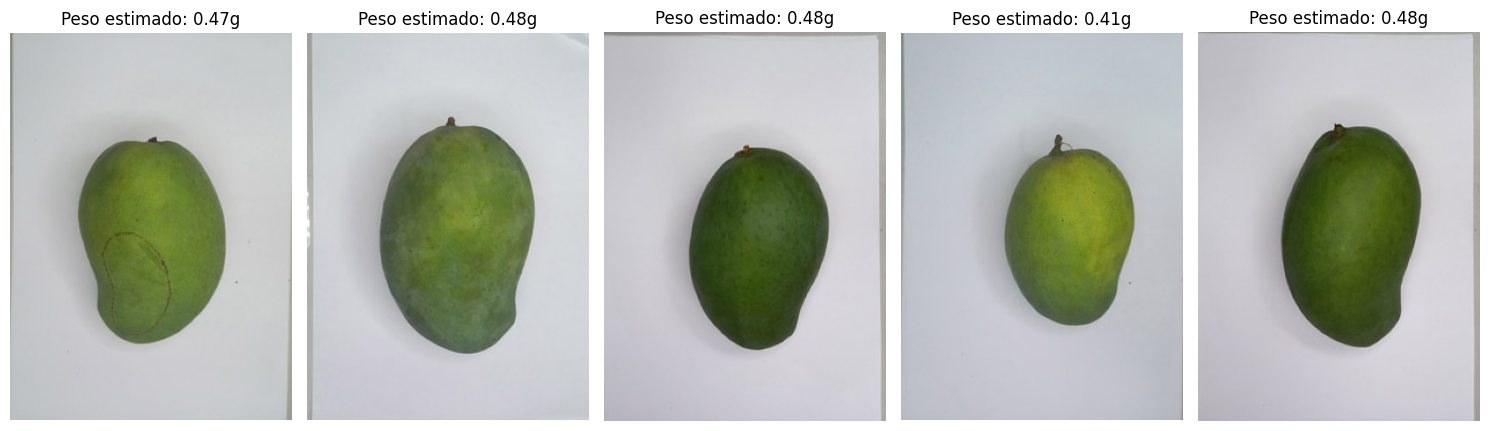

In [22]:
import matplotlib.pyplot as plt

# Seleccionar 5 imágenes de prueba
test_images = os.listdir(image_dir)[:5]  # Puedes cambiar este número o seleccionar imágenes específicas

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(15, 5))

for i, filename in enumerate(test_images):
    image_path = os.path.join(image_dir, filename)

    # Cargar y procesar la imagen
    hu_moments = process_and_extract_hu_moments(image_path)
    hu_moments = np.array(hu_moments).reshape(1, -1)  # Convertir a formato adecuado para predicción

    # Estimar el peso con el modelo
    estimated_weight = model.predict(hu_moments)[0]

    # Leer y mostrar la imagen
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB para mostrar correctamente con matplotlib

    # Mostrar la imagen con el peso estimado
    plt.subplot(1, 5, i+1)
    plt.imshow(image_rgb)
    plt.title(f'Peso estimado: {estimated_weight:.2f}g')
    plt.axis('off')

plt.tight_layout()
plt.show()
